<a href="https://colab.research.google.com/github/1chrizty/SalesIntelligence/blob/main/SalesIntelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part 2**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

sns.set_style("whitegrid")

**1. EDA**

In [ ]:
df = pd.read_csv('/content/skygeni_sales_data.csv')

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   deal_id           5000 non-null   object
 1   created_date      5000 non-null   object
 2   closed_date       5000 non-null   object
 3   sales_rep_id      5000 non-null   object
 4   industry          5000 non-null   object
 5   region            5000 non-null   object
 6   product_type      5000 non-null   object
 7   lead_source       5000 non-null   object
 8   deal_stage        5000 non-null   object
 9   deal_amount       5000 non-null   int64 
 10  sales_cycle_days  5000 non-null   int64 
 11  outcome           5000 non-null   object
dtypes: int64(2), object(10)
memory usage: 468.9+ KB


In [ ]:
df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])

df['sales_cycle_days'] = (df['closed_date'] - df['created_date']).dt.days

df['outcome_flag'] = (
    df['outcome']
      .str.strip()
      .str.lower()
      .map({'won': 1, 'lost': 0})
)

In [ ]:
overall_win_rate = df['outcome_flag'].mean()
print("Overall Win Rate:", round(overall_win_rate * 100, 2), "%")

Overall Win Rate: 45.26 %


**2. Business Insights and Custom Metrics**

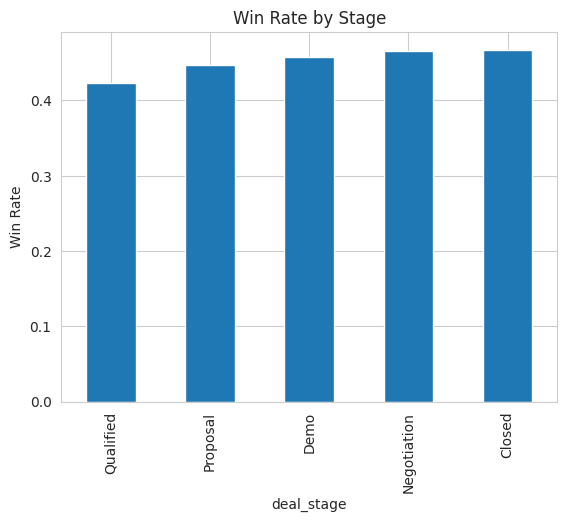

,outcome_flag
deal_stage,
Qualified,0.422594
Proposal,0.446977
Demo,0.458293
Negotiation,0.466332
Closed,0.467402


In [ ]:
stage_win = df.groupby('deal_stage')['outcome_flag'].mean().sort_values()
stage_win.plot(kind='bar', title='Win Rate by Stage')
plt.ylabel('Win Rate')
plt.show()

stage_win

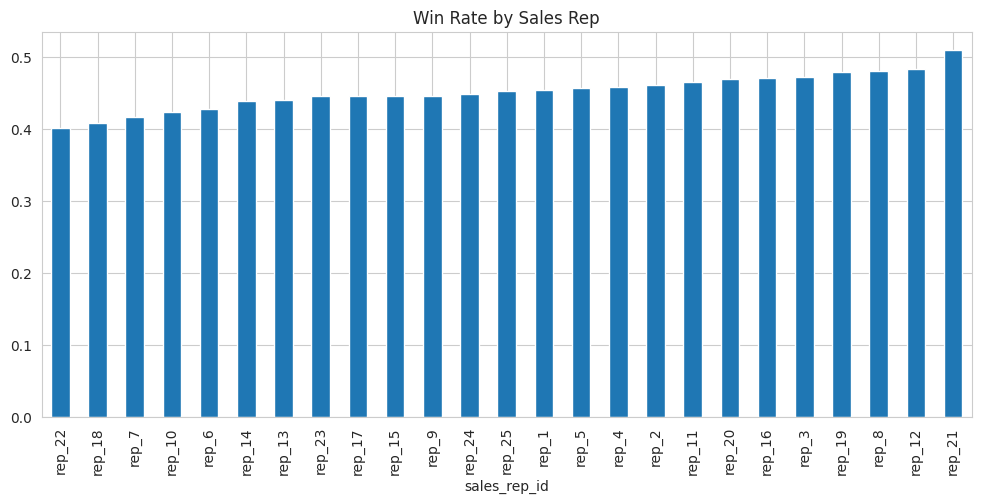

,outcome_flag
count,25.000000
mean,0.452315
std,0.024894
min,0.400943
25%,0.441026
50%,0.453659
75%,0.469565
max,0.509615


In [ ]:
rep_win = df.groupby('sales_rep_id')['outcome_flag'].mean().sort_values()

rep_win.plot(kind='bar', figsize=(12,5), title='Win Rate by Sales Rep')
plt.show()

rep_win.describe()

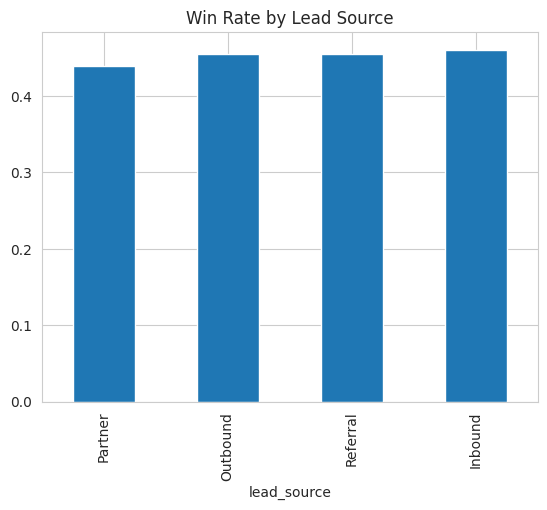

,outcome_flag
lead_source,
Partner,0.439516
Outbound,0.455056
Referral,0.455272
Inbound,0.460380


In [ ]:
lead_win = df.groupby('lead_source')['outcome_flag'].mean().sort_values()

lead_win.plot(kind='bar', title='Win Rate by Lead Source')
plt.show()

lead_win

In [ ]:
df.groupby('outcome')['deal_amount'].mean()

,deal_amount
outcome,
Lost,25883.516989
Won,26773.874503


In [ ]:
df.groupby('outcome')['sales_cycle_days'].mean()

,sales_cycle_days
outcome,
Lost,64.230179
Won,63.173221


**Qualification Leakage Rate (QLR)**

In [ ]:
qualified_deals = df[df['deal_stage'] == 'Qualified']
qlr = 1 - qualified_deals['outcome_flag'].mean()

print("Qualification Leakage Rate:", round(qlr * 100, 2), "%")

Qualification Leakage Rate: 57.74 %


**Rep Impact Index (RII)**

In [ ]:
org_win = df['outcome_flag'].mean()

rep_impact = df.groupby('sales_rep_id').agg({
    'outcome_flag': 'mean',
    'deal_id': 'count'
}).reset_index()

rep_impact['RII'] = (rep_impact['outcome_flag'] - org_win) * rep_impact['deal_id']

rep_impact.sort_values('RII', ascending=False).head()

,sales_rep_id,outcome_flag,deal_id,RII
13,rep_21,0.509615,208,11.8592
3,rep_12,0.483333,180,5.5320
23,rep_8,0.481283,187,5.3638
10,rep_19,0.479592,196,5.2904
18,rep_3,0.472222,216,4.2384


**Part 3 Decision Engine (Win Rate Driver Model)**

In [ ]:
features = ['deal_stage', 'sales_rep_id', 'industry', 'region',
            'product_type', 'lead_source']

X = pd.get_dummies(df[features], drop_first=True)
y = df['outcome_flag']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
drivers = pd.DataFrame({
    'Feature': X.columns,
    'Impact': model.coef_[0]
}).sort_values('Impact')

drivers.head(10)
drivers.tail(10)

,Feature,Impact
20,sales_rep_id_rep_25,0.045554
5,sales_rep_id_rep_11,0.058730
26,sales_rep_id_rep_8,0.061818
33,region_India,0.072496
29,industry_FinTech,0.077582
15,sales_rep_id_rep_20,0.082337
18,sales_rep_id_rep_23,0.104983
13,sales_rep_id_rep_19,0.117436
6,sales_rep_id_rep_12,0.154645
16,sales_rep_id_rep_21,0.277391


In [ ]:
def explain_deal(row):
    deal = pd.get_dummies(pd.DataFrame([row[features]]), drop_first=True)
    deal = deal.reindex(columns=X.columns, fill_value=0)

    prob = model.predict_proba(deal)[0][1]

    return f"Predicted win probability: {round(prob*100,2)}%"

df.sample(5).apply(explain_deal, axis=1)

,0
1080,Predicted win probability: 46.22%
2803,Predicted win probability: 46.22%
1114,Predicted win probability: 46.22%
343,Predicted win probability: 46.22%
2721,Predicted win probability: 46.22%


**Problem Definition-**
Which operational factors in the sales process are influencing win rate, so that the CRO can take corrective action. Therefore a system that uncovers the drivers behind win/loss behavior rather than predicting outcomes.

---

**Modeling Approach-**
Instead of complex ML models, I used:
*   One-hot encoding of categorical variables
*   Logistic Regression as an interpretable model
*   Because the goal is feature impact interpretation, not prediction accuracy.

---

**Actionable Outputs from the Model-**
Instead of using the model to say “this deal will be lost”, the model is used to say: “These factors historically reduce win rate across the organization.”

---

**How a Sales Leader Would Use This-**
A CRO or Sales Leader would not look at model scores.

They would look at insights like:


*   “Partner-sourced deals in Qualified stage are 30% more likely to be lost.”
*   “APAC + Core product deals show lower historical success.”

These insights can drive:


*   Changes in qualification criteria
*   Coaching for specific reps
*   Re-evaluation of partner lead programs
*   Stage process improvements

---

This decision engine converts historical sales data into operational guidance for the CRO by revealing the hidden drivers of win rate rather than attempting to predict deal outcomes.